## Analyzing NYC High School Data

In this project, we will explore the relationship between SAT scores and demograhic factors in NYC public schools.The [SAT](https://en.wikipedia.org/wiki/SAT), or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on [student SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) by high schools, along with additional demographic datasets. As New York city has a significant immigrant population and is very diverse, by comparing <b>demographic factors</b> such as race, income, gender,etc with SAT scores is a good way to determine whether the SAT is a fair test. However, if any demographic groups were to be consistently perform better on the SAT, analysis might have to be done to uncover reasons for that trend. 

# Read in the data

In [1]:
import pandas as pd
import numpy 
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

We have several fields in `combined` that originated from [survey of parents,teachers and students](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8). We will try to visualise the correlations these may have with the SAT scores.

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

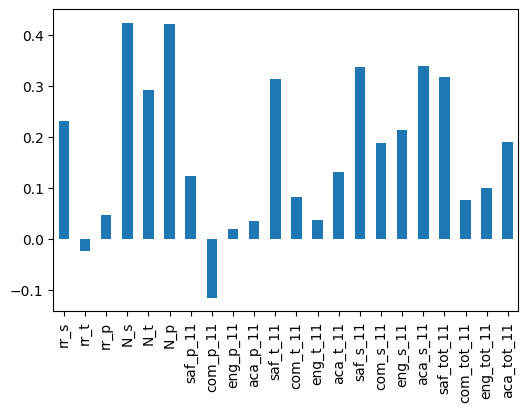

In [12]:
# Correlation bar plot
combined.corr()['sat_score'][survey_fields].plot.bar()
plt.show()

SAT scores have a positive correlation with all survey fields with the exception of _Communication Score based on Parents_ which has a weak negative correlation. Generally, if the correlation value is more than 0.25 or less than -0.25, it is justified to say that there is a interesting correlation between the values of comparison. There are a few high positive correlations with a correlation value of above 0.4 as seen below:

- Number of student respondents
- Number of parent respondents

The other notable correlation scores between 0.25 and 0.4 would include 
- Safety and Respect score based on teacher responses
- Safety and Respect score based on student responses
- Academic expectations score based on student responses
- Communication total score
- Number of teacher respondents


The high correlations between number of student,parent and teacher respondent and sat scores is expected because of the correlation we discovered sat scores had with the total enrollment ( Positive Correlation).

The high correlations between Safety and Respect score based on teacher and student responses and sat scores is possible because the environment would be more conduscive for learning for both teacher and students if there feel safer and are treated with more respect. 

The high correlation score between Communication total score and sat_score can be due to more effective learning when students and teachers are able to communicate better with one another.

The interesting correlation would be Academic expectations score based on student responses because the Academic expectations score for parents and teachers do not have a high correlation value with the sat scores

# Exploring Safety and SAT Scores

From above, we have noticed that safety score sees a high positive correlation with the sat scores. Now, we shall further explore their relationship.

Text(0.5, 0, 'Safety and Respect score based on student responses')

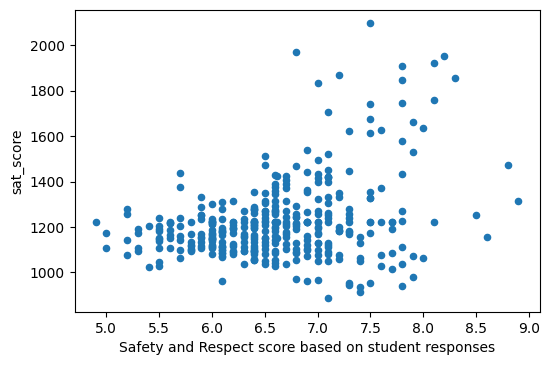

In [13]:
combined.plot.scatter('saf_s_11', 'sat_score')
plt.xlabel('Safety and Respect score based on student responses')

From the scatter plot between Safety and Respect score based on student responses and the sat_scores we can see a small positive relationship as the higher sat scores tend to see higher safety and respect score being given by the students.

In [14]:
# Compute Average Safety Score for each borough
safety_scores = combined[['boro','saf_s_11']]
grouped = safety_scores.groupby('boro')
grouped.agg(numpy.mean)

,saf_s_11
boro,
Bronx,6.606577
Brooklyn,6.370755
Manhattan,6.831370
Queens,6.721875
Staten Island,6.530000


We can observe that Manhattan and Queens have high average safety score while Brooklyn has a comparatively low average safety score.

# Explore Race and Sat Scores

Now we will move on to explore the correlation between races and respective sat scores.

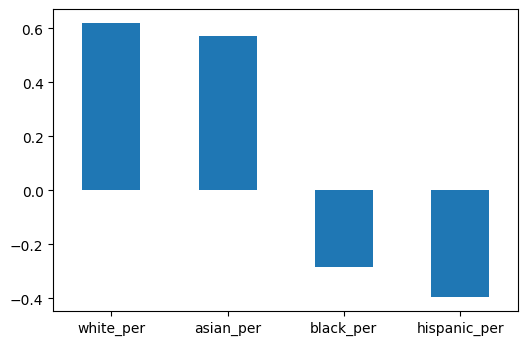

In [18]:
race_groups = ['white_per','asian_per','black_per','hispanic_per']
# plot bar graph to visualise relation between race and sat score
combined.corr()['sat_score'][race_groups].plot.bar()
plt.xticks(rotation =0)
plt.show()

The graph seems to indicate that the white and asian percentage at a given school has a positive correlation with sat scores, while the black and hispanic percentage has a negative correlation. As the hispanic percentage has a relatively strong negative correlation with sat scores, we should investigate further.

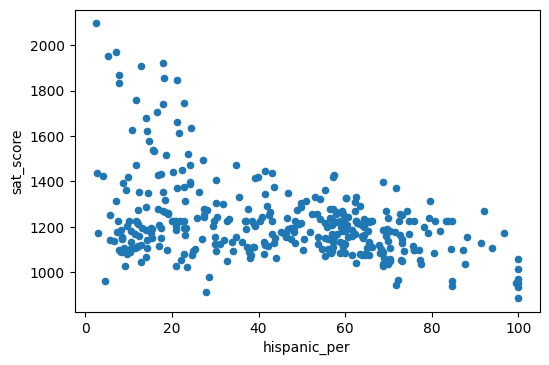

In [21]:
combined.plot.scatter('hispanic_per','sat_score')

From the scatter plot, we can observe that there are high sat scores for schoosl with low hispanic percentages but there are no high sat scores for schools with high hispanic percentages. This influence the correlation between hispanic percentage and sat score to be more strongly negative.

In [23]:
# Investigate schools with high hispanic percentages
combined[combined['hispanic_per'] > 95]


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0.0,0.0,0.0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0.0,0.0,0.0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0.0,0.0,0.0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0.0,0.0,0.0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0.0,0.0,0.0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0.0,0.0,0.0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


By investigating the schools, we can find out that these schools have a comparatively low rank in the National Rankings. These rankings are based off performances in state-required tests, graduation and how well the studens are prepared for college. Hence, this could be a contributing factor for low sat scores.

In [24]:
# Investigate Schools with low hispanic percentage and high average sat score
low_hispanic = combined['hispanic_per'] < 10
high_sat = combined['sat_score'] > 1800
combined[low_hispanic][high_sat]

<ipython-input-24-fe48a03ba15c>:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,0,0,0,0.0,0.0,0.0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,0,0,0,0.0,0.0,0.0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,0,0,0,0.0,0.0,0.0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,0,0,0,0.0,0.0,0.0,"94-50 159 Street\nJamaica, NY 11433\n(40.70099...",40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,0,0,0,0.0,0.0,0.0,"485 Clawson Street\nStaten Island, NY 10306\n(...",40.567913,-74.115362,31


The schools with high average sat scores but with a low hispanic percentage are all Specialized High Schools in which students are required to take the Specialized High School Admission Test in order to be considered for enrolment. As they are elite institutions with students handpicked based on their aptitutes, this could explain why the average sat score of the school is high.

# Exploring Gender and SAT Scores

We will move on to investigate if there is a relationship between genders and sat scores.

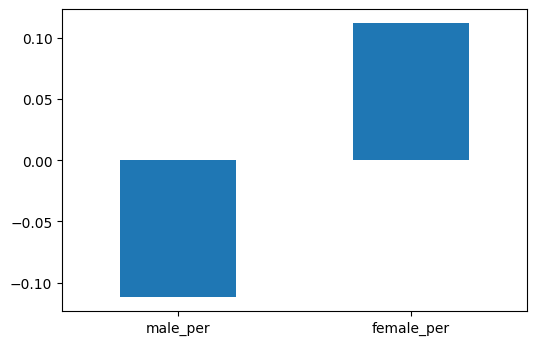

In [26]:
# Create Bar plot to show correlation between genders and sat score
genders = ['male_per','female_per']
combined.corr()['sat_score'][genders].plot.bar()
plt.xticks(rotation = 0)
plt.show()

From the graph above, we can see that there is a negative correlation between the male percentage in the school and a positive correlation between the female percentage in the school, both with the sat scores. Though, the correlation is not very strong, both being ~0.10, it is still good to investigate if the SATs are gender biased.

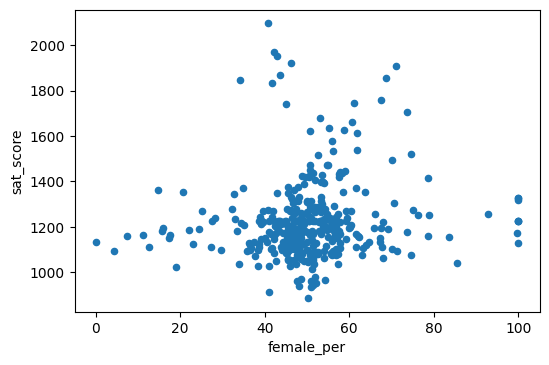

In [27]:
# Investigate Schools with high SAT scores and high female percentage
combined.plot.scatter('female_per','sat_score')
plt.show()

The scatter plot above does not hint at any obvious relationship between the female percentage and high sat scores. We should investigate further.

In [30]:
# Investigate Schools with high female percentage and high average SAT scores
high_female = combined['female_per'] > 60
high_sat_score = combined['sat_score'] > 1700
combined[high_female][high_sat_score]

<ipython-input-30-99aaa816fc85>:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0.0,0.0,0.0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0.0,0.0,0.0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0.0,0.0,0.0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0.0,0.0,0.0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


Similarly, it seems like the schools in which have a high female percentage and high average SAT scores are schools that have high standards for student enrolment. Some of these schools are also more focused on arts, which could explain why the female percentage in the school is higher.

# Exploring AP Scores vs SAT Scores

In the United States, high school students take [Advanced Placement](https://en.wikipedia.org/wiki/Advanced_Placement_exams)(AP) exams to earn college credit.

It is logical that the students at a school who took AP exams would be highly correlated with the school's SAT scores, hence we exploring this relationship further. 

In [31]:
# Get percentage of students in a school who took AP exam
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

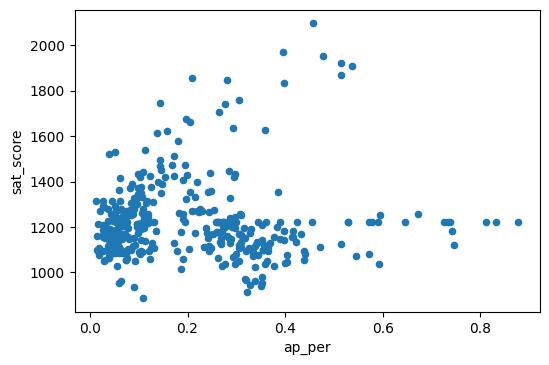

In [32]:
# Form scatter plot betwen ap scores and sat scores
combined.plot.scatter('ap_per','sat_score')

The scatter plot does hint at a lower average sat score when the school has a lower percentage in the AP Test particpation. Therefore, the sitting for the AP test may contribute towards a higher sat score.